# Modelo 2

### modelo de Computação evolucionária para prever a série temporal

In [3]:
import pandas as pd
import numpy as np
import math, random
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import itertools
from sklearn import feature_extraction,model_selection,multioutput
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import r2_score,root_mean_squared_error,mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import pmdarima as pmd

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)

In [4]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


(None, None)

In [5]:
df.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
df['date'] = pd.to_datetime(df['date'],format="%Y-%m-%d")#, format='%d.%m.%Y %H:%M:%S')
df = df.set_index('date')

df_test['date'] = pd.to_datetime(df_test['date'],format="%Y-%m-%d")#, format='%d.%m.%Y %H:%M:%S')
df_test = df_test.set_index('date')

{'whiskers': [<matplotlib.lines.Line2D at 0x1f901e06d80>,
 'caps': [<matplotlib.lines.Line2D at 0x1f901e073b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f901e06ab0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f901e07950>],
 'fliers': [],
 'means': []}

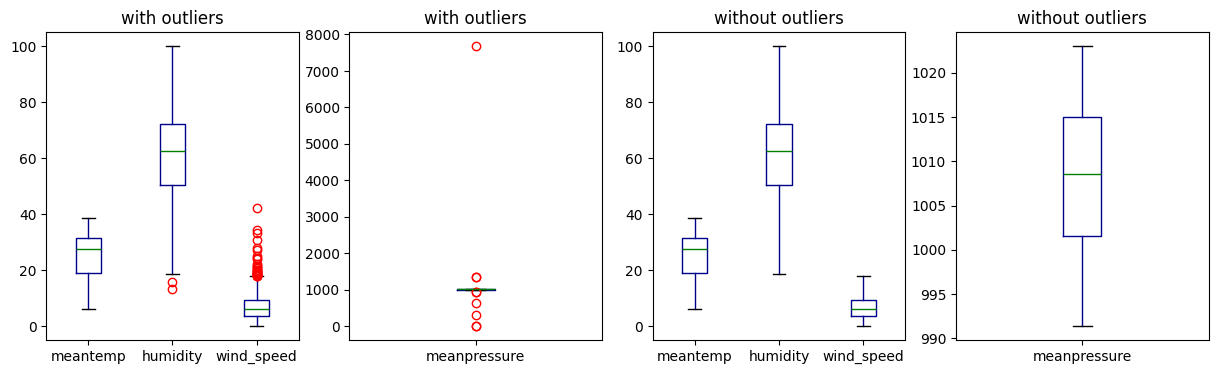

In [7]:
fig, (ax11,ax12,ax21,ax22) = plt.subplots(1,4,figsize=(15,4))
cl1 = df[list(df.columns)[:-1]]
cl2 = df[list(df.columns)[-1:]]
#plt.boxplot(cl1,)
ax11.set_title("with outliers")
ax11.boxplot(cl1, boxprops=dict(color='darkblue'),capprops=dict(color='black'),whiskerprops=dict(color='darkblue'),
flierprops=dict(color='cyan',markeredgecolor='red'),medianprops=dict(color='green'),labels=cl1.columns,showfliers=True)

ax12.set_title("with outliers")
ax12.boxplot(cl2,boxprops=dict(color='darkblue'),capprops=dict(color='black'),whiskerprops=dict(color='darkblue'),
flierprops=dict(color='cyan', markeredgecolor='red'),medianprops=dict(color='green'),labels=cl2.columns,showfliers=True)

ax21.set_title("without outliers")
ax21.boxplot(cl1, boxprops=dict(color='darkblue'),capprops=dict(color='black'),whiskerprops=dict(color='darkblue'),
flierprops=dict(color='cyan',markeredgecolor='red'),medianprops=dict(color='green'),labels=cl1.columns,showfliers=False)

ax22.set_title("without outliers")
ax22.boxplot(cl2,boxprops=dict(color='darkblue'),capprops=dict(color='black'),whiskerprops=dict(color='darkblue'),
flierprops=dict(color='cyan', markeredgecolor='red'),medianprops=dict(color='green'),labels=cl2.columns,showfliers=False)

#ax1.boxplot(df[list(df.columns)[:-1]],showfliers=False)
#ax2.boxplot(df[list(df.columns)[-1]],showfliers=False)

#df[list(df.columns)[:-1]].boxplot(showfliers=False)

In [8]:
def remove_outliers(df):
    Q1 = df['meanpressure'].quantile(0.25)
    Q3 = df['meanpressure'].quantile(0.75)
    IQR = Q3 - Q1

    filter = (df['meanpressure'] >= Q1 - 1.5 * IQR) & (df['meanpressure'] <= Q3 + 1.5 *IQR)
    df = df.loc[filter]
    return df

def remove_outliers_series(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    filter = (df >= Q1 - 1.5 * IQR) & (df <= Q3 + 1.5 *IQR)
    df = df.loc[filter]
    return df

df = remove_outliers(df)
df_test = remove_outliers(df_test)

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

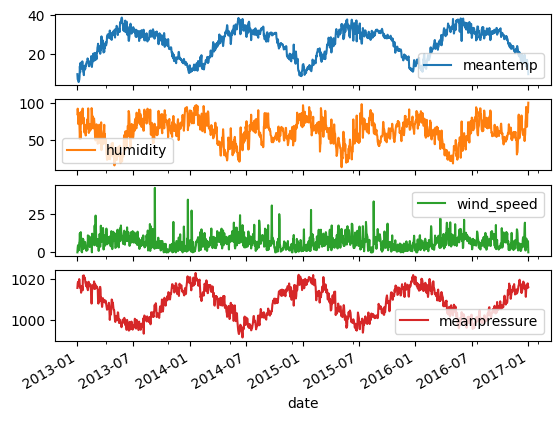

In [9]:
df.plot(subplots=True)

```python
#código para comparar quartil com z-score
sml2 = df[
    #(np.abs(stats.zscore(df)) < 3).all(axis=1)
    (np.abs(stats.zscore(df.meanpressure)) < 0.359)
]
sml2.plot(subplots=True)
diff_size1 = pd.concat([df,sml2]).drop_duplicates(keep=False)
if diff_size1.__len__() == 0:
    print("nenhuma diferença no corte dos outliers em meantemperature")
else:
    print(diff_size1)
```

```python
import pmdarima as pm
from pmdarima.model_selection import train_test_split

from pmdarima.arima import auto_arima
from pmdarima import arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
```

In [10]:
df.index = pd.DatetimeIndex(df.index).to_period('d')
df_test.index = pd.DatetimeIndex(df_test.index).to_period('d')

df.index = df.index.to_timestamp()
df_test.index = df_test.index.to_timestamp()
#df = df.asfreq('d')
#df_test = df_test.asfreq('d')

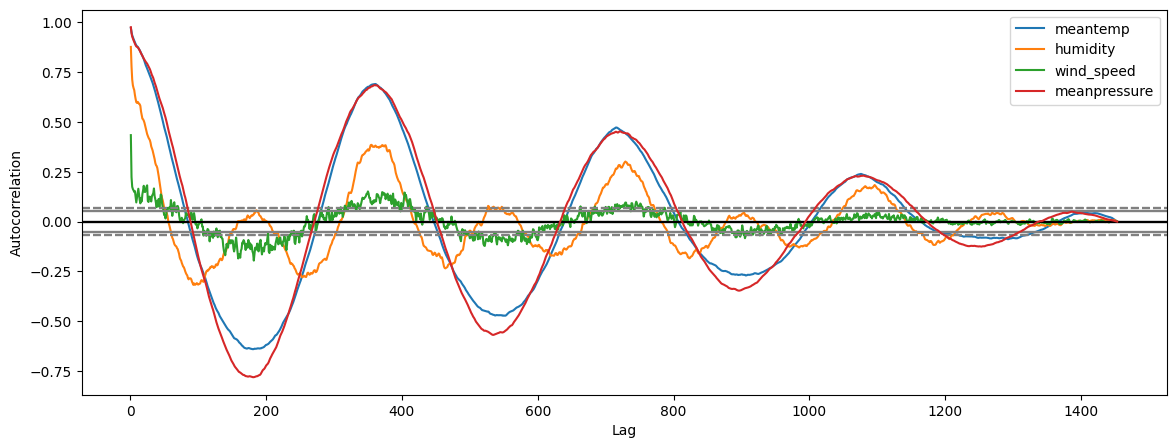

In [11]:
fig,ax = plt.subplots(1,1,figsize=(14,5))
for x in df.columns:
    autocorrelation_plot(df[x],label=x,ax=ax)
    plt.legend()

In [12]:
for i,j in enumerate(df.columns):# Test for stationarity
    print("data:",j)
    result = adfuller(df[j])
    """adf : float
            The test statistic.
        pvalue : float
            MacKinnon's approximate p-value based on MacKinnon (1994, 2010).
        usedlag : int
            The number of lags used.
        nobs : int
            The number of observations used for the ADF regression and calculation of the critical values.
        critical values : dict
            Critical values for the test statistic at the 1 %, 5 %, and 10 % levels. Based on MacKinnon (2010).
        icbest : float
            The maximized information criterion if autolag is not None.
        resstore : ResultStore, optional
            A dummy class with results attached as attributes.
    """
    print('ADF:    ', result[0])
    print('p-value:', result[1])
    print('lag:    ', result[2])
    print('nobs:   ', result[3])
    print("")
    # p-value > 0.05 ====  NOT STATIONARY
    #dados são diários + período anual == sazonalidade=365

data: meantemp
ADF:     -2.010274418658002
p-value: 0.2820863747671887
lag:     10
nobs:    1442

data: humidity
ADF:     -3.6915590680279733
p-value: 0.004233462189280554
lag:     15
nobs:    1437

data: wind_speed
ADF:     -3.8459938180878215
p-value: 0.0024702802613419056
lag:     24
nobs:    1428

data: meanpressure
ADF:     -2.135136525031492
p-value: 0.230622679715138
lag:     10
nobs:    1442



In [13]:
for i,j in enumerate(df.columns):
    dcmp1 = seasonal_decompose(df[j], model='additive', period=365)
    print(np.mean(dcmp1.resid))
    print(np.mean(dcmp1.seasonal))
    print(np.mean(dcmp1.trend),end='\n_________\n')
    #dcmp2 = seasonal_decompose(df_test[j], model='additive', period=12)
    #dcmp1.plot()
    #dcmp2.plot()
    #plt.show()

0.04311927190147748
0.061877697839798816
25.33332427689176
_________
0.11093812932460867
-0.04928686806302572
61.06912750321473
_________
-0.007420033631022254
0.00203562376714215
6.644833798527366
_________
-0.00017756696464790608
-0.051556840988885945
1008.3837268483817
_________


In [14]:
forecasted_variable = 'meantemp'
seasonal_interval = 12

model=pmd.auto_arima(df['meantemp'],start_p=1,start_q=1,test='adf',m=seasonal_interval,seasonal=True,trace=True)

In [15]:
def arima_fitness(params, variable,train,test,use_exogenous):
    p, d, q, P, D, Q = params
    try:
        #print("Fazendo o modelo")
        #print(int(p), int(d), int(q), "    ",int(P), int(D), int(Q),seasonal_interval)
        if use_exogenous:
            model = SARIMAX(
                #endog=tdiff,
                endog=train[variable],
                exog=train.drop(variable,axis=1),
                order=(int(p), int(d), int(q)),
                seasonal_order=(int(P), int(D), int(Q),seasonal_interval),
            )
        else:
            model = SARIMAX(
                #endog=tdiff,
                endog=train[variable],
                #exog=train.drop(variable,axis=1),
                order=(int(p), int(d), int(q)),
                seasonal_order=(int(P), int(D), int(Q),seasonal_interval),
            )
        #print("Fazendo o fit")
        res = model.fit()
        #print("Fazendo o forecast")
        if use_exogenous:
            forecast = res.forecast(steps=test.__len__(),exog=test.drop([variable],axis=1))
        else:
            forecast = res.forecast(steps=test.__len__())
        forecast.index = test.index
        r2 = r2_score(test[variable],forecast)
        return r2
        rmse = root_mean_squared_error(forecast,test[variable])
        predict = res.predict()

        #df[variable].plot(label='train',figsize=(12,5))
        #predict[1:].plot(label='predict',figsize=(12,5))
        #test[variable].plot(label='test',figsize=(12,5))
        #forecast.plot(label='forecast',figsize=(12,5))
        #plt.legend()
        #plt.show()

        return 1 / (rmse + 1e-6)
    except Exception as e:
        print(e)
    return 0  # Return 0 if the model fails to fit

In [16]:
def pop_generate(pop_size,param_ranges): #gerando parametros random do sarima
    return [ [random.randint(param_ranges[i][0], param_ranges[i][1]) for i in range(len(param_ranges))] for _ in range(pop_size) ]

In [17]:
def tournamentSelection(population, fitnesses, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])
        selected.append(winner[0])
    return selected

In [18]:
def linearRankingSelection(population, fitnesses):
    sorted_indices = np.argsort(fitnesses)
    ranked_population = [population[i] for i in sorted_indices]
    ranked_fitnesses = [fitnesses[i] for i in sorted_indices]

    n = len(population)
    rank_weights = [2 * (n - i) / (n * (n + 1)) for i in range(n)]
    
    selected = []
    for _ in range(len(population)):
        selected.append(ranked_population[np.random.choice(n, p=rank_weights)])
    
    return selected

In [19]:
def StochasticUniversalSampling(population, fitnesses): # Stochastic Universal Sampling (SUS)
    total_fitness = sum(fitnesses)
    point_distance = total_fitness / len(population) # distribuindo fitness pela população
    start_point = random.random() * point_distance # começo da janela
    pointers = [start_point + i * point_distance for i in range(len(population))] #janela meio aleatória de fitness que cada individuo deve entrar
    
    selected = []
    for pointer in pointers:
        cumulative_fitness = 0
        for individual, fitness in zip(population, fitnesses):
            cumulative_fitness += fitness
            if cumulative_fitness >= pointer: # os que se destacam da janela são anexados
                selected.append(individual)
                break
    return selected

In [20]:
def crossover_singlepoint(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

In [21]:
def mutate(individual,param_ranges, mutation_rate=0.01):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = random.randint(param_ranges[i][0], param_ranges[i][1])
    return individual

In [22]:
def draw_with_params(df,df_test,forecasted_variable,best_params,use_exogenous=False):
    #best_params=[3, 0, 0, 1, 1, 1]
    #best_params=[1,0,1,0,1,1]
    p, d, q, P, D, Q = best_params
    if use_exogenous:
        model = SARIMAX(
            #endog=tdiff,
            endog=df[forecasted_variable],
            exog=df.drop(forecasted_variable,axis=1),
            order=(int(p), int(d), int(q)),
            seasonal_order=(int(P), int(D), int(Q),seasonal_interval),
        )
    else:
        model = SARIMAX(
            #endog=tdiff,
            endog=df[forecasted_variable],
            #exog=df.drop(forecasted_variable,axis=1),
            order=(int(p), int(d), int(q)),
            seasonal_order=(int(P), int(D), int(Q),seasonal_interval),
        )
    res = model.fit()
    if use_exogenous:
        forecast = res.forecast(steps=df_test.__len__(),exog=df_test.drop([forecasted_variable],axis=1))
    else:
        forecast = res.forecast(steps=df_test.__len__())
    forecast.index = df_test.index
    predict = res.predict()

    df[forecasted_variable].plot(label='train',figsize=(12,5))
    pr1 = remove_outliers_series(predict)
    pr1.plot(label='predict',figsize=(12,5))
    plt.legend()
    plt.show()

    df_test[forecasted_variable].plot(label='test',figsize=(12,5))
    forecast.plot(label='forecast',figsize=(12,5))
    plt.legend()
    plt.show()

In [23]:
def GAN(forecasted_variable,df,df_test, pop_size=6, generations=20, mutation_rate=0.2, param_ranges=[(1, 4), (0, 1), (0, 4),   (0, 2), (0, 1), (0, 2),],elite_size=2,exogenous_input=False):
    #print("creating first pop")
    population = pop_generate(pop_size, param_ranges)
    #print("created first pop")
    #print("starting generations")
    for generation in range(generations):
        print("Generation",generation)
        pop_fit = [[x,arima_fitness(x,forecasted_variable,df,df_test,exogenous_input)] for x in population]
        
        pop_fit = sorted(pop_fit,key=lambda x: x[1])
        pop_fit = np.array(pop_fit,object)
        pop_elite = pop_fit[-elite_size:]
        print("pop with fits")
        for x,y in pop_fit[:-elite_size]: print(x,y)
        print("\nelite")
        for x,y in pop_elite: print(x,y)
        
        selected_few = StochasticUniversalSampling(pop_fit[:,0], pop_fit[:,1])
        if(len(selected_few) == 0):
            #print("Generation",generation)
            print("Selection failed once")
            selected_few = linearRankingSelection(pop_fit[:,0], pop_fit[:,1])
        if(len(selected_few) == 0):
            print("Selection failed twice-------------------------")
            selected_few = pop_generate(pop_size, param_ranges)
            
        new_population = pop_generate(pop_size, param_ranges)#[]
        for i in range(0, len(selected_few) - elite_size, 2):
            parent1, parent2 = selected_few[i], selected_few[i + 1]
            child1, child2 = crossover_singlepoint(parent1, parent2)
            #print("crossed",parent1,parent2)
            #print("    into",child1,child2)
            child1=mutate(child1, param_ranges, mutation_rate)
            child2=mutate(child2, param_ranges, mutation_rate)
            #print("    mut ",child1,child2)
            new_population.extend([child1, child2])
        
        #print("enhanced")
        #for x in new_population: print(x)
        # Add the elites to the new population
        new_population.extend(pop_elite[:,0])
        #print("with elite")
        #for x in new_population: print(x)
        
        # Ensure the population size remains constant
        population = new_population[-pop_size:]
        print("new_population",len(selected_few),len(population))
        for i,x in enumerate(population):
            print(x)
        
        best_individual = pop_fit[-1,0]
        best_fitness = pop_fit[-1,1]
        print(f'Generation {generation}: Best Fitness = {best_fitness}, Best SARIMAX(p,d,q,P,D,Q,m) = {best_individual}')
    
    return best_individual

In [833]:
""" best_params = GAN(forecasted_variable='meantemp',df=df,df_test=df_test,mutation_rate=0.5,
#param_ranges=[(1, 1), (1, 1), (1,1),(1, 1),(0,0),(1, 1),]
) """


" best_params = GAN(forecasted_variable='meantemp',df=df,df_test=df_test,mutation_rate=0.5,\n#param_ranges=[(1, 1), (1, 1), (1,1),(1, 1),(0,0),(1, 1),]\n) "

# Sem Componente Exógeno

### Predicting for meantemp
Generation 0: Best Fitness = -1.907317350573106, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 1, 2, 1, 0, 0]\
Generation 1: Best Fitness = -1.907317350573106, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 1, 2, 1, 0, 0]\
Generation 2: Best Fitness = -1.3647903025804982, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 3, 0, 1, 2]\
Generation 3: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 4: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 5: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 6: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 7: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 8: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 9: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 10: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 11: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 12: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 13: Best Fitness = 0.25605562172343777, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]\
Generation 14: Best Fitness = 0.43579714733386754, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 0, 0, 1, 1]\
Generation 15: Best Fitness = 0.43579714733386754, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 0, 0, 1, 1]\
Generation 16: Best Fitness = 0.43579714733386754, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 0, 0, 1, 1]\
Generation 17: Best Fitness = 0.43579714733386754, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 0, 0, 1, 1]\
Generation 18: Best Fitness = 0.43579714733386754, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 0, 0, 1, 1]\
Generation 19: Best Fitness = 0.43579714733386754, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 0, 0, 1, 1]

Melhor fitness: 0.435, usando (1, 0, 0), (0, 1, 1)

![title](img/meantemp_pred.png)
![title](img/meantemp_fcst.png)

### Predicting for humidity
Generation 0: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]\
Generation 1: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]\
Generation 2: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]\
Generation 3: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]\
Generation 4: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]\
Generation 5: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]\
Generation 6: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]\
Generation 7: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]\
Generation 8: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]\
Generation 9: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 10: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 11: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 12: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 13: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 14: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 15: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 16: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 17: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 18: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]\
Generation 19: Best Fitness = 0.5412521077375783, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 0 0 0 0]

Melhor fitness: 0.541 usando (1,0,0) (0,0,0)

![title](img/humidity_pred.png)
![title](img/humidity_fcst.png)

### Predicting for wind_speed
Generation 0: Best Fitness = -0.37972271672941993, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 1, 4, 2, 1, 2]\
Generation 1: Best Fitness = -0.26161326749884384, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 4, 2, 1, 1]\
Generation 2: Best Fitness = -0.24038276106652368, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 2, 2, 1, 1]\
Generation 3: Best Fitness = -0.24038276106652368, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 2, 2, 1, 1]\
Generation 4: Best Fitness = -0.24038276106652368, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 2, 2, 1, 1]\
Generation 5: Best Fitness = -0.24038276106652368, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 2, 2, 1, 1]\
Generation 6: Best Fitness = -0.24038276106652368, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 2, 2, 1, 1]\
Generation 7: Best Fitness = -0.24038276106652368, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 2, 2, 1, 1]\
Generation 8: Best Fitness = -0.24038276106652368, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 2, 2, 1, 1]\
Generation 9: Best Fitness = -0.18145505301701093, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 0, 2, 1, 2]\
Generation 10: Best Fitness = -0.18092029897380635, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 0, 2, 1, 1]\
Generation 11: Best Fitness = -0.18092029897380635, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 0, 2, 1, 1]\
Generation 12: Best Fitness = -0.18092029897380635, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 0, 2, 1, 1]\
Generation 13: Best Fitness = -0.18036962505349097, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 0, 2, 1, 1]\
Generation 14: Best Fitness = -0.18036962505349097, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 0, 2, 1, 1]\
Generation 15: Best Fitness = -0.18036962505349097, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 0, 2, 1, 1]\
Generation 16: Best Fitness = -0.17493369527618952, Best SARIMAX(p,d,q,P,D,Q,m) = [2 0 0 1 1 1]\
Generation 17: Best Fitness = -0.17493369527618952, Best SARIMAX(p,d,q,P,D,Q,m) = [2 0 0 1 1 1]\
Generation 18: Best Fitness = -0.17493369527618952, Best SARIMAX(p,d,q,P,D,Q,m) = [2 0 0 1 1 1]\
Generation 19: Best Fitness = -0.17493369527618952, Best SARIMAX(p,d,q,P,D,Q,m) = [2 0 0 1 1 1]

Melhor Fitness: -0.17 usando (2,0,0) (1,1,1)

![title](img/wind_speed_pred.png)
![title](img/wind_speed_fcst.png)

### Predicting for meanpressure
Generation 0: Best Fitness = 0.3440079447474391, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 0, 1, 2]\
Generation 1: Best Fitness = 0.3440079447474391, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 0, 1, 2]\
Generation 2: Best Fitness = 0.3479224137955982, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 2, 1, 1]\
Generation 3: Best Fitness = 0.3479224137955982, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 2, 1, 1]\
Generation 4: Best Fitness = 0.3479224137955982, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 2, 1, 1]\
Generation 5: Best Fitness = 0.3479224137955982, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 2, 1, 1]\
Generation 6: Best Fitness = 0.3479224137955982, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 2, 1, 1]\
Generation 7: Best Fitness = 0.3479224137955982, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 2, 1, 1]\
Generation 8: Best Fitness = 0.3479224137955982, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 2, 1, 1]\
Generation 9: Best Fitness = 0.3479224137955982, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 2, 1, 1]\
Generation 10: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]\
Generation 11: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]\
Generation 12: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]\
Generation 13: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]\
Generation 14: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]\
Generation 15: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]\
Generation 16: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]\
Generation 17: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]\
Generation 18: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]\
Generation 19: Best Fitness = 0.3837412056916236, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]

Melhor fitness: 0.384 usando (3,0,0) (2,1,2)

![title](img/meanpressure_pred.png)
![title](img/meanpressure_fcst.png)

Predicting for meantemp
Generation 0
pop with fits
[4, 1, 1, 1, 1, 0] -14.149280756668054
[2, 0, 4, 0, 0, 2] -2.4346415592786124
[1, 1, 3, 2, 0, 1] -2.2887470443163984
[3, 1, 3, 1, 0, 2] -2.2676073531685255

elite
[1, 0, 2, 0, 1, 0] -2.229835891999134
[2, 1, 2, 1, 0, 0] -1.907317350573106
new_population 3 6
[3, 0, 4, 1, 0, 0]
[4, 1, 0, 1, 0, 0]
[4 1 1 1 1 0]
[4 1 1 1 1 0]
[1, 0, 2, 0, 1, 0]
[2, 1, 2, 1, 0, 0]
Generation 0: Best Fitness = -1.907317350573106, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 1, 2, 1, 0, 0]
Generation 1
pop with fits
[4 1 1 1 1 0] -14.149280756668054
[4 1 1 1 1 0] -14.149280756668054
[3, 0, 4, 1, 0, 0] -9.942514759024355
[4, 1, 0, 1, 0, 0] -2.5136887921732503

elite
[1, 0, 2, 0, 1, 0] -2.229835891999134
[2, 1, 2, 1, 0, 0] -1.907317350573106
new_population 4 6
[3, 1, 3, 0, 0, 1]
[1, 0, 3, 0, 1, 2]
[3 0 1 2 1 0]
[2 1 0 0 1 0]
[1, 0, 2, 0, 1, 0]
[2, 1, 2, 1, 0, 0]
Generation 1: Best Fitness = -1.907317350573106, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 1, 2, 1, 0, 0]
Generation 2


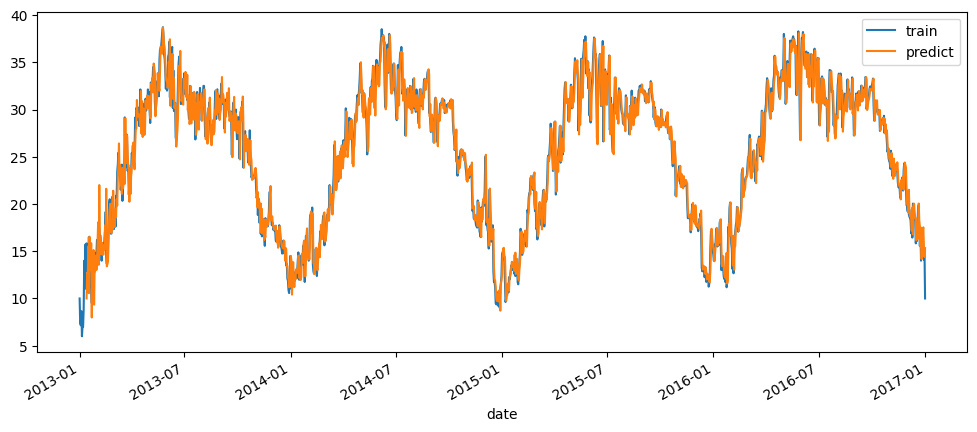

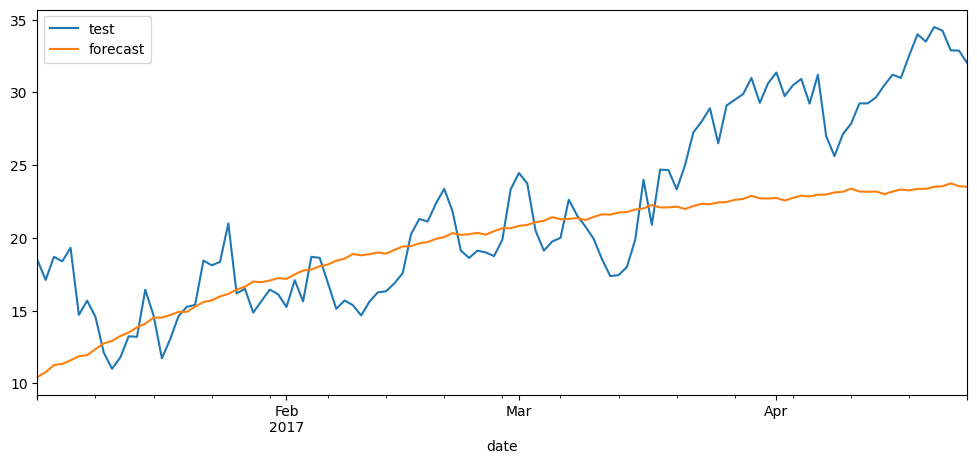

Predicting for humidity
Generation 0
pop with fits
[1, 1, 0, 0, 0, 2] -5.331148230569397
[3, 0, 2, 2, 1, 0] -4.0674509471221025
[3, 1, 2, 2, 1, 2] -2.5401748642970468
[1, 1, 2, 0, 1, 1] -2.436741921323969

elite
[3, 1, 4, 1, 0, 1] -2.2306752508090675
[2, 0, 1, 2, 0, 0] 0.2996322837709263
new_population 4 6
[3, 1, 4, 2, 0, 2]
[2, 1, 3, 2, 1, 1]
[1 1 2 0 1 2]
[1 1 0 1 0 1]
[3, 1, 4, 1, 0, 1]
[2, 0, 1, 2, 0, 0]
Generation 0: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]
Generation 1
pop with fits
[1 1 0 1 0 1] -5.302626427019594
[2, 1, 3, 2, 1, 1] -2.5947068915363576
[1 1 2 0 1 2] -2.4245835206260105
[3, 1, 4, 2, 0, 2] -2.4079977126929104

elite
[3, 1, 4, 1, 0, 1] -2.2306752508090675
[2, 0, 1, 2, 0, 0] 0.2996322837709263
new_population 4 6
[1, 0, 1, 0, 1, 2]
[3, 1, 4, 2, 0, 0]
[1 0 3 0 0 2]
[4 1 0 1 0 1]
[3, 1, 4, 1, 0, 1]
[2, 0, 1, 2, 0, 0]
Generation 1: Best Fitness = 0.2996322837709263, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 1, 2, 0, 0]
Generation 2


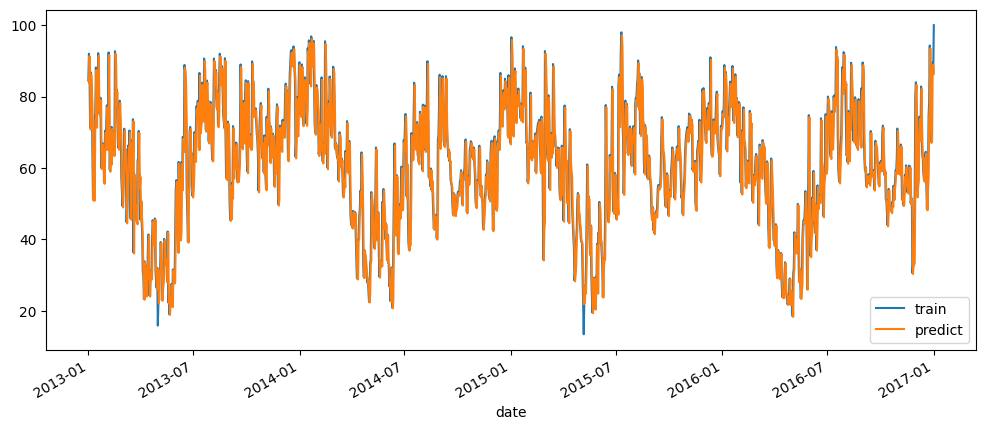

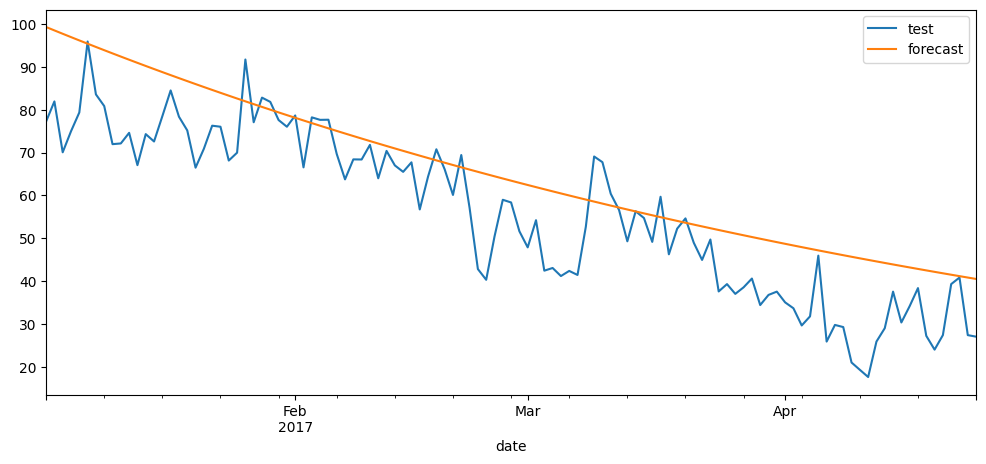

Predicting for wind_speed
Generation 0
pop with fits
[1, 0, 0, 2, 1, 0] -0.9177449024922919
[1, 0, 2, 2, 0, 0] -0.48122739880212384
[2, 0, 1, 2, 0, 0] -0.4722266408430733
[4, 1, 3, 1, 1, 2] -0.4003583380880289

elite
[4, 1, 2, 1, 1, 2] -0.3945379464368024
[3, 1, 4, 2, 1, 2] -0.37972271672941993
new_population 4 6
[4, 0, 4, 2, 1, 1]
[4, 1, 4, 2, 1, 0]
[1 0 1 2 1 0]
[2 0 0 0 0 0]
[4, 1, 2, 1, 1, 2]
[3, 1, 4, 2, 1, 2]
Generation 0: Best Fitness = -0.37972271672941993, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 1, 4, 2, 1, 2]
Generation 1
pop with fits
[2 0 0 0 0 0] -5.2113400939795795
[1 0 1 2 1 0] -0.9297373723360673
[4, 1, 4, 2, 1, 0] -0.8754817291971382
[4, 1, 2, 1, 1, 2] -0.3945379464368024

elite
[3, 1, 4, 2, 1, 2] -0.37972271672941993
[4, 0, 4, 2, 1, 1] -0.26161326749884384
new_population 2 6
[3, 1, 4, 1, 0, 1]
[3, 1, 2, 0, 0, 1]
[3, 0, 2, 1, 1, 0]
[4, 0, 2, 2, 1, 1]
[3, 1, 4, 2, 1, 2]
[4, 0, 4, 2, 1, 1]
Generation 1: Best Fitness = -0.26161326749884384, Best SARIMAX(p,d,q,P,D,Q,m) = [4, 0, 

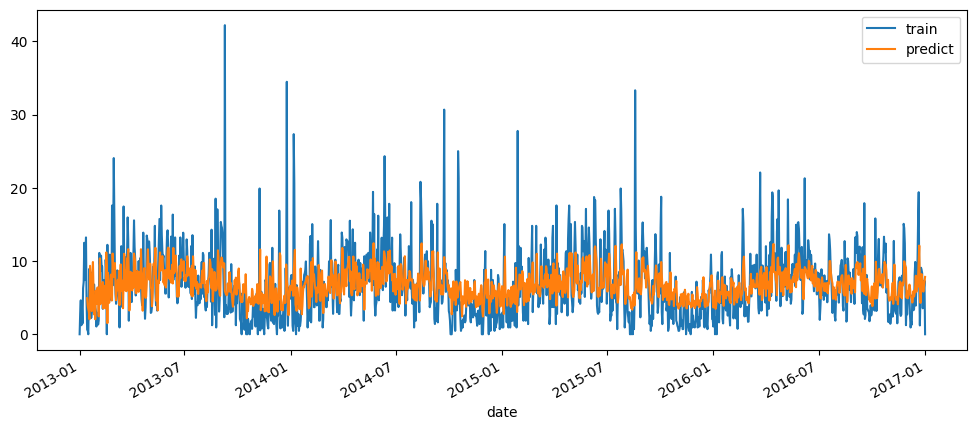

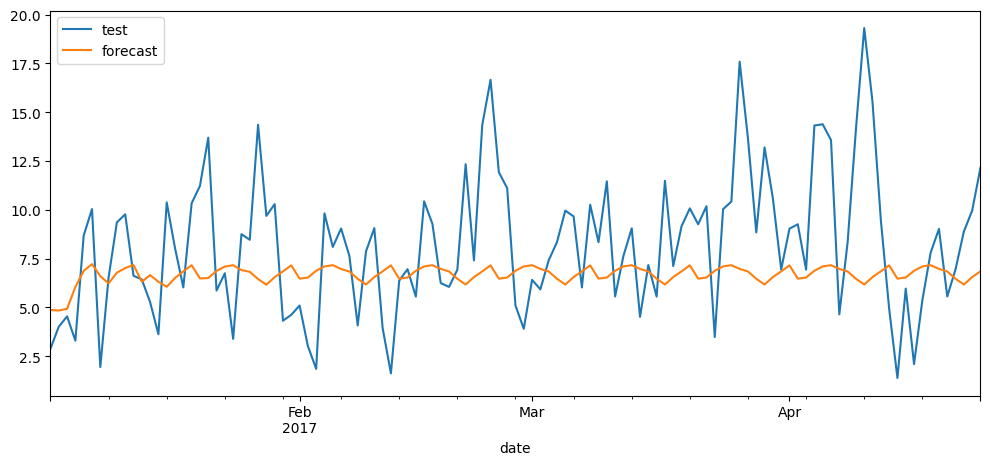

Predicting for meanpressure
Generation 0
LU decomposition error.
pop with fits
[2, 1, 1, 2, 1, 0] -1.4459765258226258
[2, 1, 0, 0, 0, 2] -0.5167970949653835
[2, 1, 2, 2, 1, 2] -0.42569487756556756
[4, 1, 4, 1, 0, 0] -0.351129649397828

elite
[4, 0, 1, 1, 0, 1] 0
[1, 0, 2, 0, 1, 2] 0.3440079447474391
new_population 3 6
[1, 0, 4, 0, 0, 1]
[2, 0, 4, 2, 1, 0]
[4 1 1 2 0 0]
[2 1 0 0 0 2]
[4, 0, 1, 1, 0, 1]
[1, 0, 2, 0, 1, 2]
Generation 0: Best Fitness = 0.3440079447474391, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 0, 1, 2]
Generation 1
LU decomposition error.
pop with fits
[2, 0, 4, 2, 1, 0] -0.6063036503030359
[2 1 0 0 0 2] -0.5167970949653835
[1, 0, 4, 0, 0, 1] -0.4627294900866008
[4 1 1 2 0 0] -0.4516440822514649

elite
[4, 0, 1, 1, 0, 1] 0
[1, 0, 2, 0, 1, 2] 0.3440079447474391
new_population 4 6
[1, 0, 2, 2, 1, 1]
[3, 0, 2, 2, 1, 2]
[3 0 1 2 1 0]
[2 0 2 0 1 1]
[4, 0, 1, 1, 0, 1]
[1, 0, 2, 0, 1, 2]
Generation 1: Best Fitness = 0.3440079447474391, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 2, 0, 

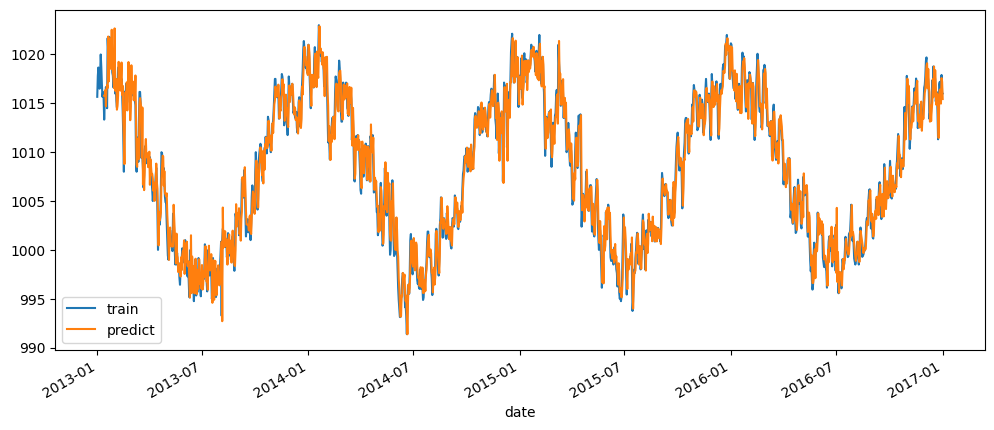

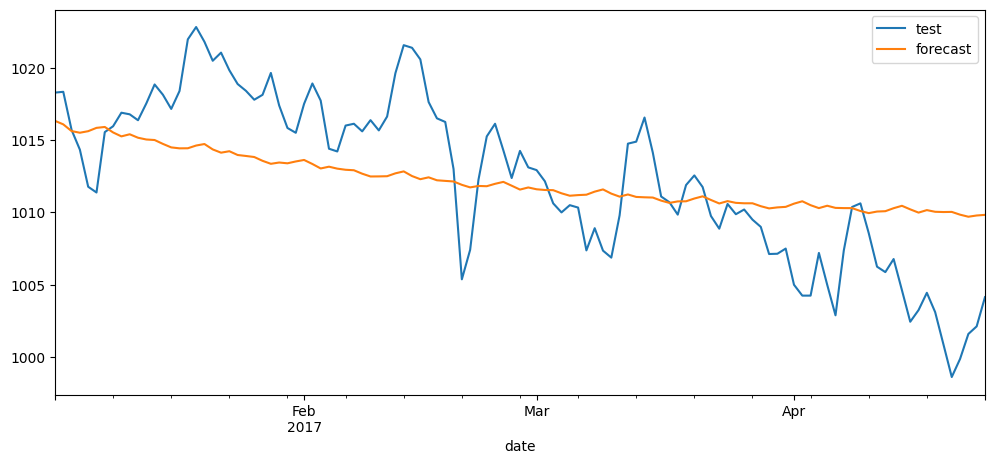

In [834]:
for x in df.columns:
    print("Predicting for",x)
    best_params = GAN(forecasted_variable=x,df=df,df_test=df_test,mutation_rate=0.5)
    draw_with_params(df,df_test,x,best_params)

# Utilizando Componente exógeno

Predicting for meantemp
Generation 0
pop with fits
[3, 0, 3, 2, 1, 0] -0.1995740421724086
[3, 1, 2, 2, 0, 0] 0.3926720750347974

elite
[1, 0, 2, 1, 1, 0] 0.41090861513269616
[1, 0, 0, 1, 0, 2] 0.4802837727021724
new_population 4 4
[3 1 2 1 1 0]
[1 0 2 2 0 0]
[1, 0, 2, 1, 1, 0]
[1, 0, 0, 1, 0, 2]
Generation 0: Best Fitness = 0.4802837727021724, Best SARIMAX(p,d,q,P,D,Q,m) = [1, 0, 0, 1, 0, 2]
Generation 1
pop with fits
[3 1 2 1 1 0] -2.8889841386378206
[1, 0, 2, 1, 1, 0] 0.41090861513269616

elite
[1, 0, 0, 1, 0, 2] 0.4802837727021724
[1 0 2 2 0 0] 0.6934407208954407
Selection failed once
new_population 4 4
[1 0 2 2 1 0]
[1 0 0 0 1 2]
[1, 0, 0, 1, 0, 2]
[1 0 2 2 0 0]
Generation 1: Best Fitness = 0.6934407208954407, Best SARIMAX(p,d,q,P,D,Q,m) = [1 0 2 2 0 0]
Generation 2
pop with fits
[1 0 2 2 1 0] 0.4001644483270781
[1, 0, 0, 1, 0, 2] 0.4802837727021724

elite
[1 0 2 2 0 0] 0.6934407208954407
[1 0 0 0 1 2] 0.7832555234352392
new_population 4 4
[1 1 0 2 0 1]
[2 0 2 2 0 2]
[1 0 2 2 0 0]


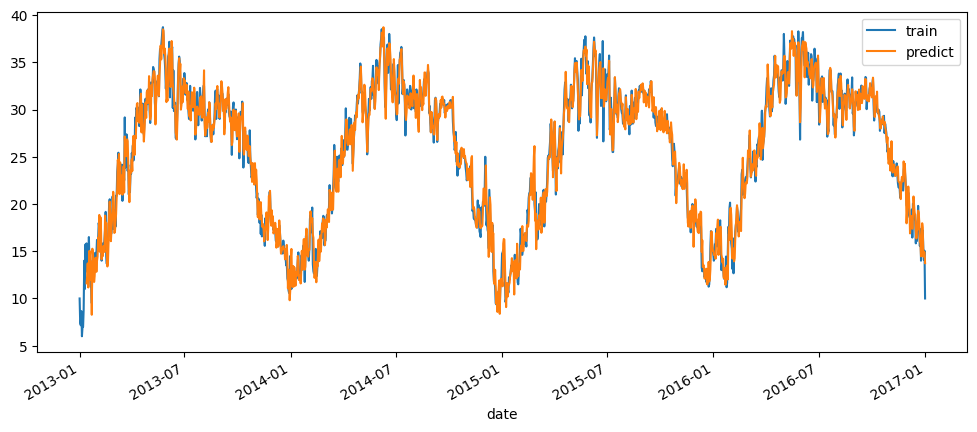

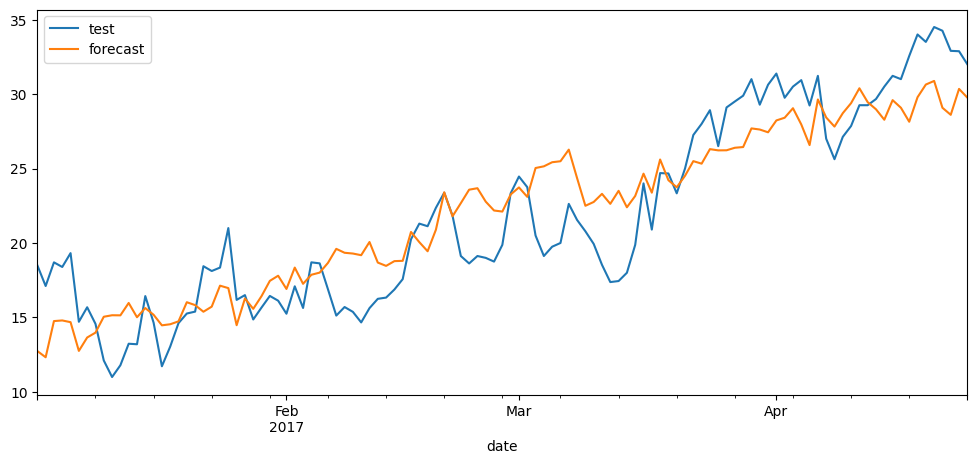

Predicting for humidity
Generation 0
pop with fits
[2, 0, 0, 2, 0, 0] 0.13777251475795638
[3, 0, 2, 2, 0, 1] 0.1581628553761788

elite
[1, 1, 3, 0, 1, 0] 0.47520523867282405
[3, 0, 1, 0, 1, 2] 0.5908580874104589
new_population 4 4
[1 0 2 0 0 1]
[1 1 2 0 1 1]
[1, 1, 3, 0, 1, 0]
[3, 0, 1, 0, 1, 2]
Generation 0: Best Fitness = 0.5908580874104589, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 1, 0, 1, 2]
Generation 1
pop with fits
[1 0 2 0 0 1] 0.32491368038584134
[1, 1, 3, 0, 1, 0] 0.47520523867282405

elite
[3, 0, 1, 0, 1, 2] 0.5908580874104589
[1 1 2 0 1 1] 0.6656089122648838
new_population 4 4
[1 1 3 0 1 0]
[1 1 3 0 0 1]
[3, 0, 1, 0, 1, 2]
[1 1 2 0 1 1]
Generation 1: Best Fitness = 0.6656089122648838, Best SARIMAX(p,d,q,P,D,Q,m) = [1 1 2 0 1 1]
Generation 2
pop with fits
[1 1 3 0 1 0] 0.47520523867282405
[3, 0, 1, 0, 1, 2] 0.5908580874104589

elite
[1 1 2 0 1 1] 0.6656089122648838
[1 1 3 0 0 1] 0.6828110174334433
new_population 4 4
[3 0 3 0 1 2]
[3 1 1 0 0 0]
[1 1 2 0 1 1]
[1 1 3 0 0 1]
Generat

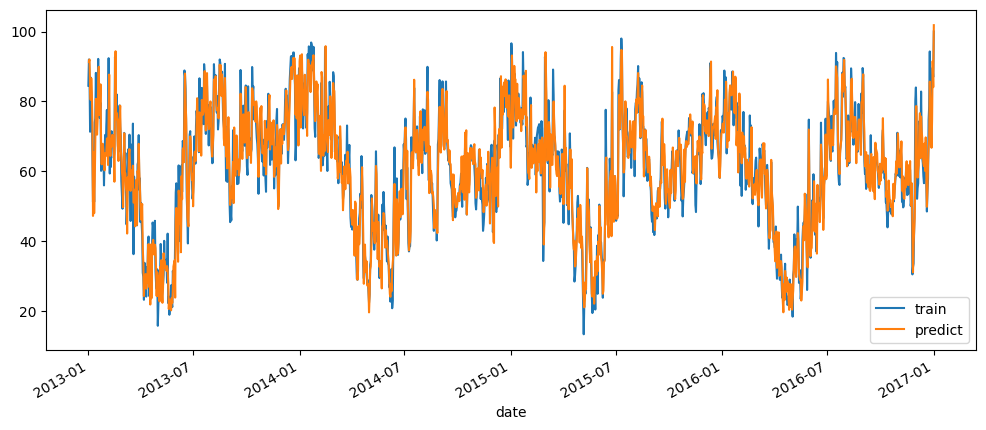

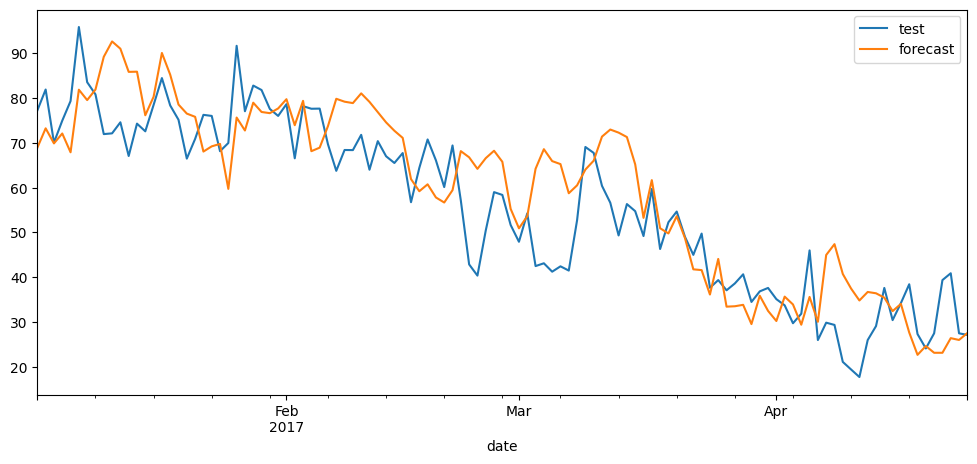

Predicting for wind_speed
Generation 0
pop with fits
[1, 0, 0, 0, 1, 0] -1.4577209215718763
[1, 0, 0, 1, 1, 1] -0.1611560292472276

elite
[3, 0, 1, 2, 0, 2] -0.08939342799729078
[3, 0, 0, 1, 0, 2] -0.07446742989584254
new_population 1 4
[1, 0, 0, 0, 1, 0]
[2, 1, 0, 0, 1, 1]
[3, 0, 1, 2, 0, 2]
[3, 0, 0, 1, 0, 2]
Generation 0: Best Fitness = -0.07446742989584254, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 0, 1, 0, 2]
Generation 1
pop with fits
[1, 0, 0, 0, 1, 0] -1.4577209215718763
[2, 1, 0, 0, 1, 1] -0.318736407721107

elite
[3, 0, 1, 2, 0, 2] -0.08939342799729078
[3, 0, 0, 1, 0, 2] -0.07446742989584254
new_population 1 4
[2, 1, 1, 1, 0, 1]
[3, 0, 1, 2, 1, 0]
[3, 0, 1, 2, 0, 2]
[3, 0, 0, 1, 0, 2]
Generation 1: Best Fitness = -0.07446742989584254, Best SARIMAX(p,d,q,P,D,Q,m) = [3, 0, 0, 1, 0, 2]
Generation 2
pop with fits
[3, 0, 1, 2, 1, 0] -0.5454802002924335
[3, 0, 1, 2, 0, 2] -0.08939342799729078

elite
[3, 0, 0, 1, 0, 2] -0.07446742989584254
[2, 1, 1, 1, 0, 1] 0.0033053444001887033
new_pop

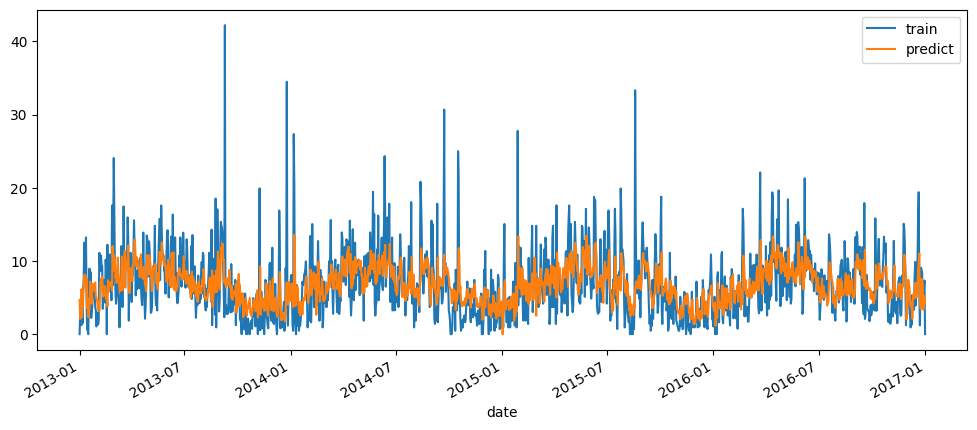

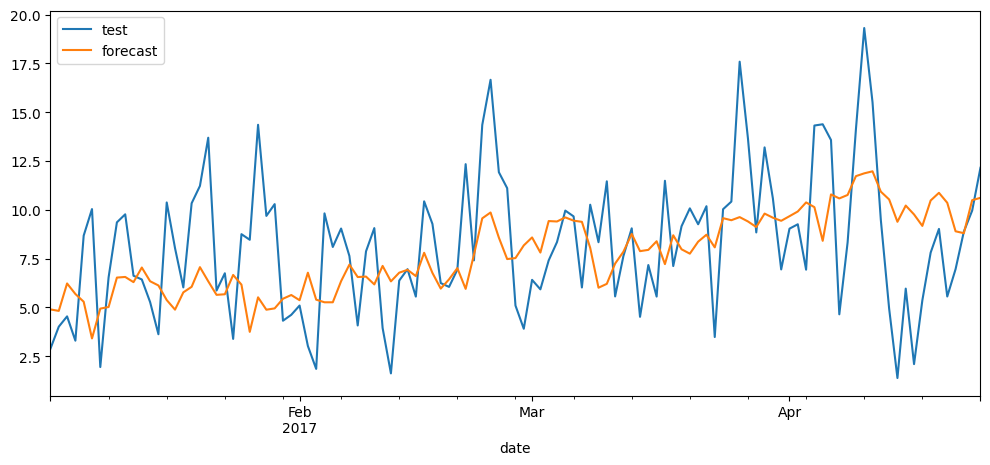

Predicting for meanpressure
Generation 0
LU decomposition error.
pop with fits
[1, 0, 2, 2, 0, 2] -0.4100716501221078
[1, 0, 1, 2, 0, 2] 0

elite
[2, 0, 2, 1, 0, 0] 0.13156890143981026
[2, 0, 0, 2, 1, 1] 0.4074436627241158
new_population 4 4
[1 0 0 2 1 2]
[3 0 0 2 1 2]
[2, 0, 2, 1, 0, 0]
[2, 0, 0, 2, 1, 1]
Generation 0: Best Fitness = 0.4074436627241158, Best SARIMAX(p,d,q,P,D,Q,m) = [2, 0, 0, 2, 1, 1]
Generation 1
pop with fits
[2, 0, 2, 1, 0, 0] 0.13156890143981026
[2, 0, 0, 2, 1, 1] 0.4074436627241158

elite
[1 0 0 2 1 2] 0.4431004504228976
[3 0 0 2 1 2] 0.5019080610605795
new_population 4 4
[2 0 2 1 0 0]
[2 1 2 2 1 0]
[1 0 0 2 1 2]
[3 0 0 2 1 2]
Generation 1: Best Fitness = 0.5019080610605795, Best SARIMAX(p,d,q,P,D,Q,m) = [3 0 0 2 1 2]
Generation 2
pop with fits
[2 0 2 1 0 0] 0.13156890143981026
[1 0 0 2 1 2] 0.4431004504228976

elite
[2 1 2 2 1 0] 0.5003566439864469
[3 0 0 2 1 2] 0.5019080610605795
new_population 4 4
[2 0 2 2 0 1]
[1 0 3 2 1 0]
[2 1 2 2 1 0]
[3 0 0 2 1 2]
Generat

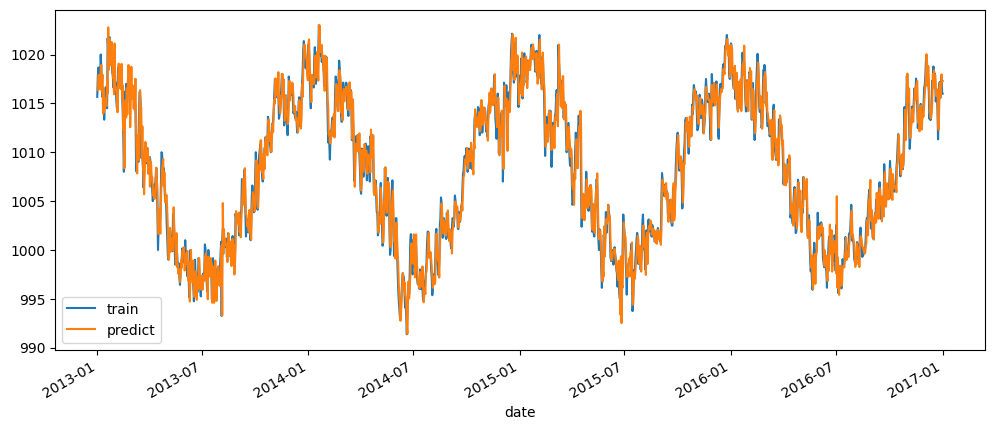

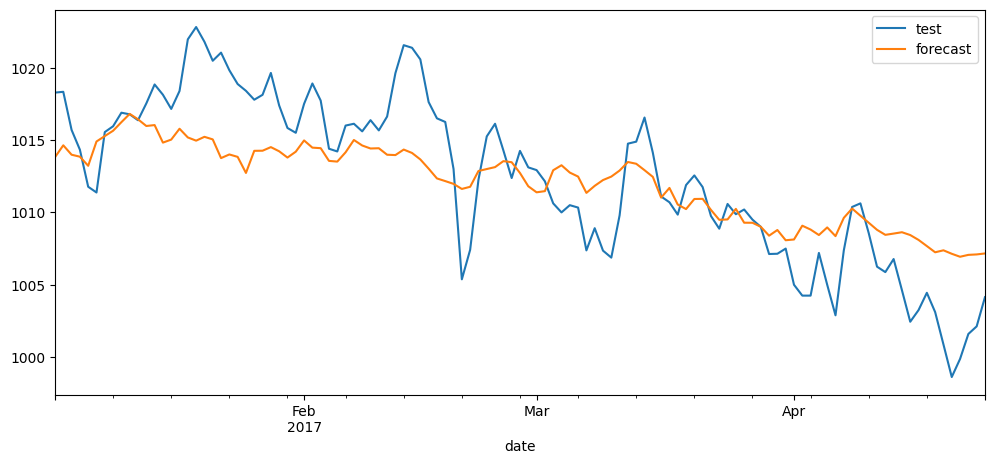

In [24]:
for x in df.columns:
    print("Predicting for",x)
    best_params = GAN(forecasted_variable=x,pop_size=4,df=df,df_test=df_test,mutation_rate=0.5,exogenous_input=True,
                      param_ranges=[(1, 3), (0, 1), (0, 3),   (0, 2), (0, 1), (0, 2),])
    draw_with_params(df,df_test,x,best_params,use_exogenous=True)